In [1]:
from sklearn.cluster import KMeans
from unicodedata import normalize
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.cluster import KMeans

from scipy import stats


import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('ggplot')

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()
% matplotlib inline

import json
import holoviews as hv
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Range1d, NumeralTickFormatter, FixedTicker, Legend
from bokeh.palettes import Set1_7, RdBu5, RdBu11

#output_notebook()
hv.extension('bokeh')

Loading BokehJS ...

UsageError: Line magic function `%` not found.


In [43]:
file = r'data/TX RENDIMENTO MUNICIPIOS 2010.xls'
column_labels = [
    'ano', 'regiao', 'uf', 'codigo_municipio', 'nome_municipio', 'localizacao', 'rede',
    'aprovacao_fundamental_1', 'aprovacao_fundamental_2', 'aprovacao_fundamental_3',
    'aprovacao_fundamental_4', 'aprovacao_fundamental_5', 'aprovacao_fundamental_6',
    'aprovacao_fundamental_7', 'aprovacao_fundamental_8', 'aprovacao_fundamental_9',
    'aprovacao_fundamental_1:5', 'aprovacao_fundamental_6:9', 'aprovacao_fundamental_1:9',
    'aprovacao_medio_1', 'aprovacao_medio_2', 'aprovacao_medio_3', 'aprovacao_medio_4',
    'aprovacao_medio_0', 'aprovacao_medio_0:4',
    'reprovacao_fundamental_1', 'reprovacao_fundamental_2', 'reprovacao_fundamental_3',
    'reprovacao_fundamental_4', 'reprovacao_fundamental_5', 'reprovacao_fundamental_6',
    'reprovacao_fundamental_7', 'reprovacao_fundamental_8', 'reprovacao_fundamental_9',
    'reprovacao_fundamental_1:5', 'reprovacao_fundamental_6:9', 'reprovacao_fundamental_1:9',
    'reprovacao_medio_1', 'reprovacao_medio_2', 'reprovacao_medio_3', 'reprovacao_medio_4',
    'reprovacao_medio_0', 'reprovacao_medio_0:4',
    'abandono_fundamental_1', 'abandono_fundamental_2', 'abandono_fundamental_3',
    'abandono_fundamental_4', 'abandono_fundamental_5', 'abandono_fundamental_6',
    'abandono_fundamental_7', 'abandono_fundamental_8', 'abandono_fundamental_9',
    'abandono_fundamental_1:5', 'abandono_fundamental_6:9', 'abandono_fundamental_1:9',
    'abandono_medio_1', 'abandono_medio_2', 'abandono_medio_3', 'abandono_medio_4',
    'abandono_medio_0', 'abandono_medio_0:4',
]
df_municipios = pd.read_excel(file, skiprows=8, nrows=65460, names=column_labels, na_values='--')
df_municipios.head()

,ano,regiao,uf,codigo_municipio,nome_municipio,localizacao,rede,aprovacao_fundamental_1,aprovacao_fundamental_2,aprovacao_fundamental_3,...,abandono_fundamental_9,abandono_fundamental_1:5,abandono_fundamental_6:9,abandono_fundamental_1:9,abandono_medio_1,abandono_medio_2,abandono_medio_3,abandono_medio_4,abandono_medio_0,abandono_medio_0:4
0,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Estadual,100.0,35.1,70.6,...,NaN,3.4,6.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Municipal,97.9,88.3,88.6,...,11.0,1.2,10.3,6.1,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Publico,98.1,79.3,86.0,...,11.0,1.6,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Total,98.1,79.3,86.0,...,11.0,1.6,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Total,Estadual,98.2,83.3,82.0,...,8.2,2.0,9.2,6.1,18.3,12.1,8.4,NaN,NaN,14.1


In [44]:
normalize_string = lambda x: normalize('NFKD', x.upper()).encode('ASCII','ignore').decode("utf-8")

file = r'data/pib_municipios.xls'
df_pib_municipios = pd.read_excel(file, usecols=[0,5], skiprows=8, names=['local', 'pib'], nrows=5601).dropna()
df_pib_municipios['local'] = df_pib_municipios['local'].apply(normalize_string)

df_pib_municipios.head()

,local,pib
0,NORTE,2.015107e+08
1,RONDONIA,2.356064e+07
2,ALTA FLORESTA D'OESTE,3.356437e+05
3,ALTO ALEGRE DOS PARECIS,1.590252e+05
4,ALTO PARAISO,2.015904e+05


In [45]:
municipio_to_pib = {
    'AROEIRA DO ITAIM': 'AROEIRAS DO ITAIM',
    'BARRA D ALCANTARA': 'BARRA D\'ALCANTARA',
    'BATAIPORA': 'BATAYPORA',
    'BELA VISTA DO CAROBA': 'BELA VISTA DA CAROBA',
    'BELEM DE SAO FRANCISCO': 'BELEM DO SAO FRANCISCO',
    'CHIAPETA': 'CHIAPETTA',
    'COUTO DE MAGALHAES': 'COUTO MAGALHAES',
    'CUVERLANDIA': 'CURVELANDIA',
    'GOIO-ERE': 'GOIOERE',
    'GOVERNADOR LOMANTO JUNIOR': 'BARRO PRETO',
    'ITAMARACA': 'ILHA DE ITAMARACA',
    'LAGOA DO ITAENGA': 'LAGOA DE ITAENGA',
    'OLHO D AGUA DO PIAUI': 'OLHO D\'AGUA DO PIAUI',
    'OLHOS-D AGUA': 'OLHOS-D\'AGUA',
    'PARATI': 'PARATY',
    'PASSA VINTE': 'PASSA-VINTE',
    'PICARRAS': 'BALNEARIO PICARRAS',
    'PINDARE MIRIM': 'PINDARE-MIRIM',
    'PINGO D AGUA': 'PINGO-D\'AGUA',
    'SANTANA DO LIVRAMENTO': 'SANT\'ANA DO LIVRAMENTO',
    'SAO DOMINGOS DE POMBAL': 'POMBAL',
    'SAO FELIPE D OESTE': 'SAO FELIPE D\'OESTE',
    'SAO VALERIO DA NATIVIDADE': 'SAO VALERIO',
    'SAO VICENTE DO SERIDO': 'SERIDO',
    'SEM PEIXE': 'SEM-PEIXE',
    'TOCOS DO MOGI': 'TOCOS DO MOJI',
    'TRAJANO DE MORAIS': 'TRAJANO DE MORAES'
}

pib_to_municipio = {
    'MOJI MIRIM': 'MOGI MIRIM',
}

df_municipios.replace(municipio_to_pib, inplace=True)
df_pib_municipios.replace(pib_to_municipio, inplace=True)

df_municipios = df_municipios[df_municipios.nome_municipio != 'CAMPO DE SANTANA']

In [46]:
df_municipios = pd.merge(df_municipios, df_pib_municipios, left_on='nome_municipio', right_on='local', how='left')
df_municipios.drop(['local'], axis=1, inplace=True)

df_municipios

,ano,regiao,uf,codigo_municipio,nome_municipio,localizacao,rede,aprovacao_fundamental_1,aprovacao_fundamental_2,aprovacao_fundamental_3,...,abandono_fundamental_1:5,abandono_fundamental_6:9,abandono_fundamental_1:9,abandono_medio_1,abandono_medio_2,abandono_medio_3,abandono_medio_4,abandono_medio_0,abandono_medio_0:4,pib
0,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Estadual,100.0,35.1,70.6,...,3.4,6.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,3.356437e+05
1,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Municipal,97.9,88.3,88.6,...,1.2,10.3,6.1,NaN,NaN,NaN,NaN,NaN,NaN,3.356437e+05
2,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Publico,98.1,79.3,86.0,...,1.6,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.356437e+05
3,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Total,98.1,79.3,86.0,...,1.6,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.356437e+05
4,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Total,Estadual,98.2,83.3,82.0,...,2.0,9.2,6.1,18.3,12.1,8.4,NaN,NaN,14.1,3.356437e+05
5,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Total,Municipal,98.6,84.8,87.5,...,1.0,10.3,5.2,NaN,NaN,NaN,NaN,NaN,NaN,3.356437e+05
6,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Total,Particular,100.0,NaN,NaN,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.356437e+05
7,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Total,Publico,98.5,84.3,85.2,...,1.5,9.6,5.6,18.3,12.1,8.4,NaN,NaN,14.1,3.356437e+05
8,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Total,Total,98.6,84.3,85.2,...,1.4,9.6,5.5,18.3,12.1,8.4,NaN,NaN,14.1,3.356437e+05
9,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Urbana,Estadual,97.8,98.3,84.0,...,1.8,9.3,6.2,18.3,12.1,8.4,NaN,NaN,14.1,3.356437e+05


In [47]:
df_municipios = df_municipios[df_municipios.localizacao != "Total"]
df_municipios = df_municipios[df_municipios.rede != "Total"]

df_municipios.head()

,ano,regiao,uf,codigo_municipio,nome_municipio,localizacao,rede,aprovacao_fundamental_1,aprovacao_fundamental_2,aprovacao_fundamental_3,...,abandono_fundamental_1:5,abandono_fundamental_6:9,abandono_fundamental_1:9,abandono_medio_1,abandono_medio_2,abandono_medio_3,abandono_medio_4,abandono_medio_0,abandono_medio_0:4,pib
0,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Estadual,100.0,35.1,70.6,...,3.4,6.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,335643.702
1,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Municipal,97.9,88.3,88.6,...,1.2,10.3,6.1,NaN,NaN,NaN,NaN,NaN,NaN,335643.702
2,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Publico,98.1,79.3,86.0,...,1.6,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,335643.702
9,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Urbana,Estadual,97.8,98.3,84.0,...,1.8,9.3,6.2,18.3,12.1,8.4,NaN,NaN,14.1,335643.702
10,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Urbana,Municipal,99.4,79.5,85.4,...,0.3,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN,335643.702


In [58]:
aprovados = ['aprovacao_fundamental_1', 'aprovacao_fundamental_2', 'aprovacao_fundamental_3',
    'aprovacao_fundamental_4', 'aprovacao_fundamental_5', 'aprovacao_fundamental_6',
    'aprovacao_fundamental_7', 'aprovacao_fundamental_8', 'aprovacao_fundamental_9',
    'aprovacao_fundamental_1:5', 'aprovacao_fundamental_6:9', 'aprovacao_fundamental_1:9',
    'aprovacao_medio_1', 'aprovacao_medio_2', 'aprovacao_medio_3', 'aprovacao_medio_4',
    'aprovacao_medio_0', 'aprovacao_medio_0:4']
reprovados = ['reprovacao_fundamental_1', 'reprovacao_fundamental_2', 'reprovacao_fundamental_3',
    'reprovacao_fundamental_4', 'reprovacao_fundamental_5', 'reprovacao_fundamental_6',
    'reprovacao_fundamental_7', 'reprovacao_fundamental_8', 'reprovacao_fundamental_9',
    'reprovacao_fundamental_1:5', 'reprovacao_fundamental_6:9', 'reprovacao_fundamental_1:9',
    'reprovacao_medio_1', 'reprovacao_medio_2', 'reprovacao_medio_3', 'reprovacao_medio_4',
    'reprovacao_medio_0', 'reprovacao_medio_0:4']
abandonos = ['abandono_fundamental_1', 'abandono_fundamental_2', 'abandono_fundamental_3',
    'abandono_fundamental_4', 'abandono_fundamental_5', 'abandono_fundamental_6',
    'abandono_fundamental_7', 'abandono_fundamental_8', 'abandono_fundamental_9',
    'abandono_fundamental_1:5', 'abandono_fundamental_6:9', 'abandono_fundamental_1:9',
    'abandono_medio_1', 'abandono_medio_2', 'abandono_medio_3', 'abandono_medio_4',
    'abandono_medio_0', 'abandono_medio_0:4']

### Clusterizacao dos dados

In [48]:
df_municipios.head()
df_muni = df_municipios.drop(columns=[ 'regiao', 'uf', 'ano', 'nome_municipio', 'rede', 'localizacao', 'codigo_municipio'])

In [176]:
df_muni = df_muni.dropna()
model = KMeans(n_clusters=5, tol=0.00003, max_iter=100).fit(df_muni.values)

model.labels_


array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [177]:
df_label = pd.DataFrame(model.labels_, columns=['labels'])
df_municipios.reset_index(drop=True, inplace=True)
df_labels_reg = pd.concat([df_municipios, df_label], axis=1)
df_labels_reg.head()


,ano,regiao,uf,codigo_municipio,nome_municipio,localizacao,rede,aprovacao_fundamental_1,aprovacao_fundamental_2,aprovacao_fundamental_3,...,abandono_fundamental_6:9,abandono_fundamental_1:9,abandono_medio_1,abandono_medio_2,abandono_medio_3,abandono_medio_4,abandono_medio_0,abandono_medio_0:4,pib,labels
0,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Estadual,100.0,35.1,70.6,...,6.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,335643.702,0
1,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Municipal,97.9,88.3,88.6,...,10.3,6.1,NaN,NaN,NaN,NaN,NaN,NaN,335643.702,0
2,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Rural,Publico,98.1,79.3,86.0,...,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,335643.702,0
3,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Urbana,Estadual,97.8,98.3,84.0,...,9.3,6.2,18.3,12.1,8.4,NaN,NaN,14.1,335643.702,0
4,2010,Norte,RO,1100015,ALTA FLORESTA D'OESTE,Urbana,Municipal,99.4,79.5,85.4,...,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN,335643.702,0


In [178]:
df_cluster0 = df_labels_reg.loc[df_labels_reg['labels'] == 0]
df_cluster1 = df_labels_reg.loc[df_labels_reg['labels'] == 1]
df_cluster2 = df_labels_reg.loc[df_labels_reg['labels'] == 2]
df_cluster3 = df_labels_reg.loc[df_labels_reg['labels'] == 3]
df_cluster4 = df_labels_reg.loc[df_labels_reg['labels'] == 4]

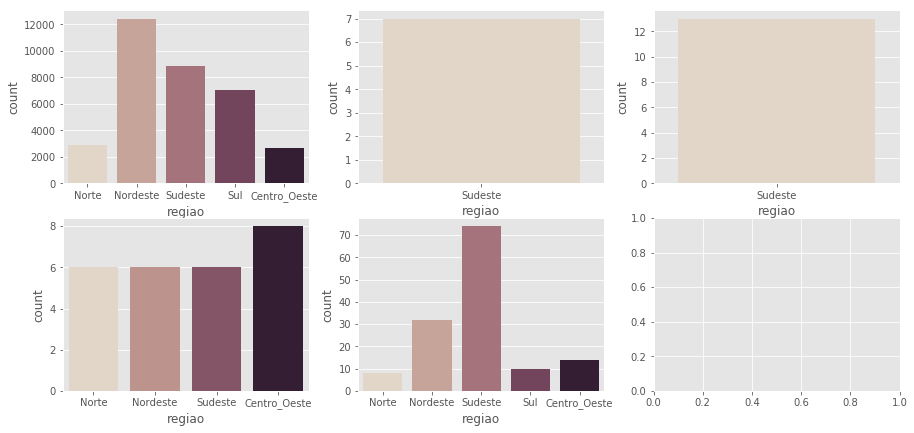

In [179]:
fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(15,7))

sns.countplot(df_cluster0['regiao'], ax=axes[0][0], palette="ch:.25")
sns.countplot(df_cluster1['regiao'], ax=axes[0][1], palette="ch:.25")
sns.countplot(df_cluster2['regiao'], ax=axes[0][2], palette="ch:.25")
sns.countplot(df_cluster3['regiao'], ax=axes[1][0], palette="ch:.25")
sns.countplot(df_cluster4['regiao'], ax=axes[1][1], palette="ch:.25")

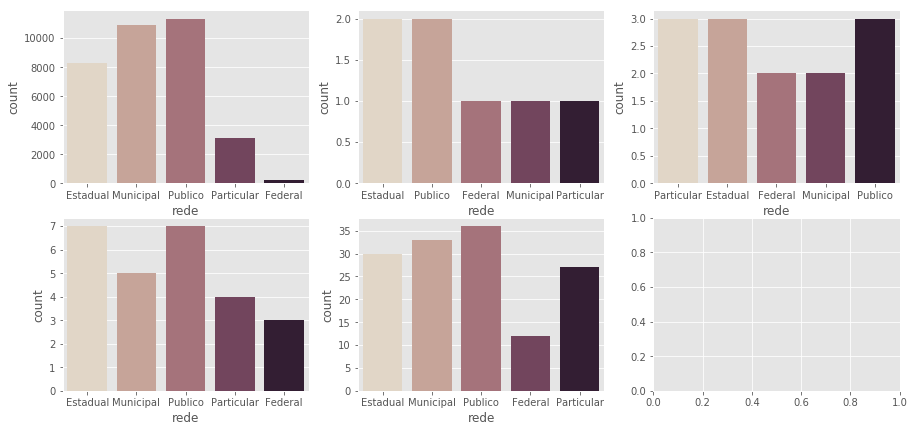

In [180]:
fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(15,7))

sns.countplot(df_cluster0['rede'], ax=axes[0][0], palette="ch:.25")
sns.countplot(df_cluster1['rede'], ax=axes[0][1], palette="ch:.25")
sns.countplot(df_cluster2['rede'], ax=axes[0][2], palette="ch:.25")
sns.countplot(df_cluster3['rede'], ax=axes[1][0], palette="ch:.25")
sns.countplot(df_cluster4['rede'], ax=axes[1][1], palette="ch:.25")

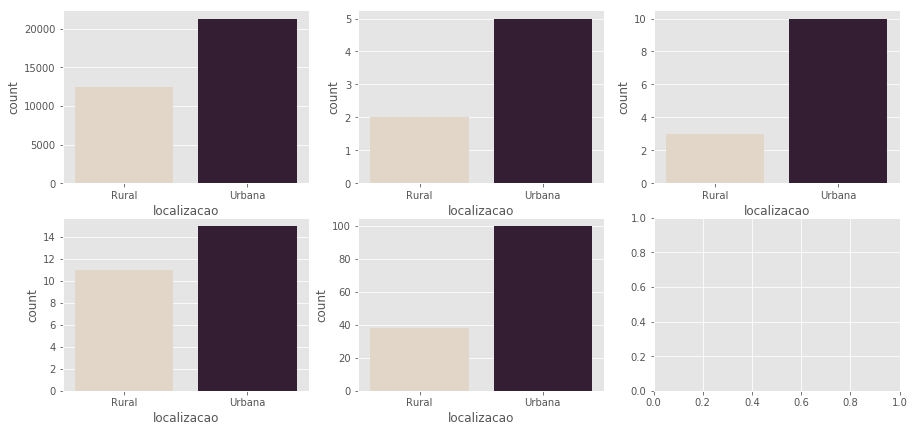

In [181]:
fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(15,7))

sns.countplot(df_cluster0['localizacao'], ax=axes[0][0], palette="ch:.25")
sns.countplot(df_cluster1['localizacao'], ax=axes[0][1], palette="ch:.25")
sns.countplot(df_cluster2['localizacao'], ax=axes[0][2], palette="ch:.25")
sns.countplot(df_cluster3['localizacao'], ax=axes[1][0], palette="ch:.25")
sns.countplot(df_cluster4['localizacao'], ax=axes[1][1], palette="ch:.25")

In [182]:

df_cluster0_resultados = pd.DataFrame()
df_cluster0_resultados['aprovados'] = df_cluster0[aprovados].mean(axis=1)
df_cluster0_resultados['reprovados'] = df_cluster0[reprovados].mean(axis=1)
df_cluster0_resultados['abandonos'] = df_cluster0[abandonos].mean(axis=1)
df_cluster0_resultados_regiao =  pd.concat([df_cluster0_resultados, df_cluster0['regiao']], axis=1)
df_cluster0_resultados_regiao.reset_index(inplace=True, drop=True)

df_cluster0_resultados_regiao.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:358: RuntimeWarning: divide by zero encountered in true_divide
  the_mean = the_sum / count


,aprovados,reprovados,abandonos,regiao
0,70.350000,25.390000,4.260000,Norte
1,86.041667,8.366667,5.591667,Norte
2,83.833333,10.583333,5.583333,Norte
3,80.856250,11.875000,7.268750,Norte
4,88.540000,11.220000,0.240000,Norte


In [183]:
df_cluster0_resultados_regiao.set_index('regiao', inplace=True)


In [184]:
df_cluster0_resultados_regiao = df_cluster0_resultados_regiao.mean(axis=0, level='regiao')
df_cluster0_resultados_regiao


,aprovados,reprovados,abandonos
regiao,,,
Norte,84.116517,9.734405,6.149078
Nordeste,82.695379,10.832895,6.471726
Sudeste,90.872271,6.844638,2.283092
Sul,90.316931,7.792571,1.890498
Centro_Oeste,88.341878,8.038682,3.619440


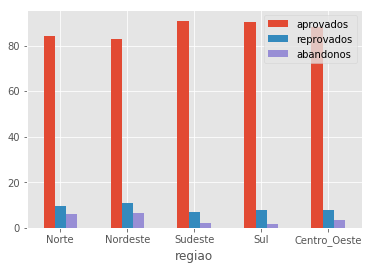

In [185]:
ax = df_cluster0_resultados_regiao.plot.bar(rot=0)


In [186]:

df_cluster1_resultados = pd.DataFrame()
df_cluster1_resultados['aprovados'] = df_cluster1[aprovados].mean(axis=1)
df_cluster1_resultados['reprovados'] = df_cluster1[reprovados].mean(axis=1)
df_cluster1_resultados['abandonos'] = df_cluster1[abandonos].mean(axis=1)
df_cluster1_resultados_regiao =  pd.concat([df_cluster1_resultados, df_cluster1['regiao']], axis=1)
df_cluster1_resultados_regiao.reset_index(inplace=True, drop=True)

In [187]:
#ax = df_cluster1_resultados_regiao.plot.bar(rot=1)
df_cluster1_resultados_regiao.set_index('regiao', inplace=True)
df_cluster1_resultados_regiao

,aprovados,reprovados,abandonos
regiao,,,
Sudeste,90.681250,8.087500,1.231250
Sudeste,90.681250,8.087500,1.231250
Sudeste,89.612500,8.168750,2.218750
Sudeste,96.100000,3.900000,0.000000
Sudeste,90.188235,8.205882,1.605882
Sudeste,96.729412,3.247059,0.023529
Sudeste,90.123529,7.788235,2.088235


In [188]:

df_cluster1_resultados_regiao = df_cluster1_resultados_regiao.mean(axis=0, level='regiao')
df_cluster1_resultados_regiao

,aprovados,reprovados,abandonos
regiao,,,
Sudeste,92.016597,6.783561,1.199842


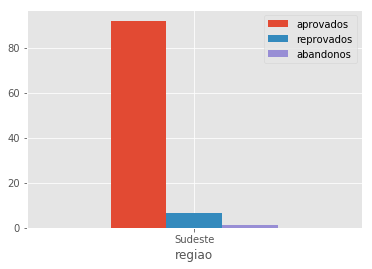

In [189]:
ax = df_cluster1_resultados_regiao.plot.bar(rot=0)


In [190]:
df_cluster2_resultados = pd.DataFrame()
df_cluster2_resultados['aprovados'] = df_cluster2[aprovados].mean(axis=1)
df_cluster2_resultados['reprovados'] = df_cluster2[reprovados].mean(axis=1)
df_cluster2_resultados['abandonos'] = df_cluster2[abandonos].mean(axis=1)
df_cluster2_resultados_regiao =  pd.concat([df_cluster2_resultados, df_cluster2['regiao']], axis=1)
df_cluster2_resultados_regiao.reset_index(inplace=True, drop=True)

In [191]:
df_cluster2_resultados_regiao.set_index('regiao', inplace=True)


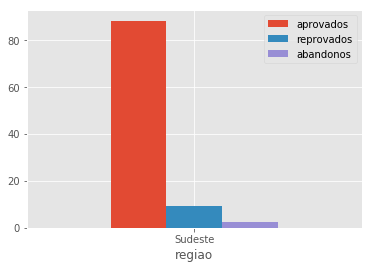

In [192]:
df_cluster2_resultados_regiao = df_cluster2_resultados_regiao.mean(axis=0, level='regiao')
ax = df_cluster2_resultados_regiao.plot.bar(rot=0)

In [193]:
df_cluster3_resultados = pd.DataFrame()
df_cluster3_resultados['aprovados'] = df_cluster3[aprovados].mean(axis=1)
df_cluster3_resultados['reprovados'] = df_cluster3[reprovados].mean(axis=1)
df_cluster3_resultados['abandonos'] = df_cluster3[abandonos].mean(axis=1)
df_cluster3_resultados_regiao =  pd.concat([df_cluster3_resultados, df_cluster3['regiao']], axis=1)
df_cluster3_resultados_regiao.reset_index(inplace=True, drop=True)

In [194]:
df_cluster3_resultados_regiao.set_index('regiao', inplace=True)

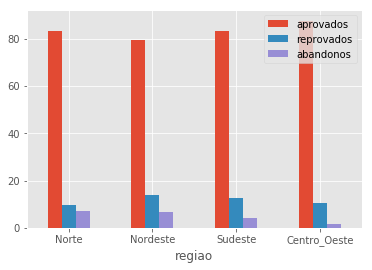

In [195]:
df_cluster3_resultados_regiao = df_cluster3_resultados_regiao.mean(axis=0, level='regiao')
ax = df_cluster3_resultados_regiao.plot.bar(rot=0)


In [196]:
df_cluster4_resultados = pd.DataFrame()
df_cluster4_resultados['aprovados'] = df_cluster4[aprovados].mean(axis=1)
df_cluster4_resultados['reprovados'] = df_cluster4[reprovados].mean(axis=1)
df_cluster4_resultados['abandonos'] = df_cluster4[abandonos].mean(axis=1)
df_cluster4_resultados_regiao =  pd.concat([df_cluster4_resultados, df_cluster4['regiao']], axis=1)
df_cluster4_resultados_regiao.reset_index(inplace=True, drop=True)

In [197]:
df_cluster4_resultados_regiao.set_index('regiao', inplace=True)


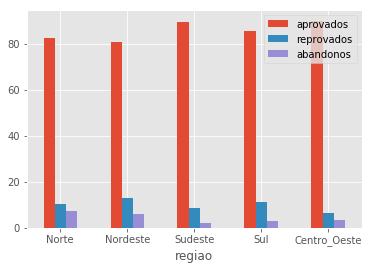

In [198]:
df_cluster4_resultados_regiao = df_cluster4_resultados_regiao.mean(axis=0, level='regiao')
ax = df_cluster4_resultados_regiao.plot.bar(rot=0)
